## Creating a logistic regression model in Python!

In [1]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [3]:
ride_ids = ['15669']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [4]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15669
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181107203025_Ocean.CSV
Ride data has been uploaded.
                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850  1.243585e+09    -6.0   363.0  -107.0  -366.0   
        2018-11-07 20:30:35.883           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 20:30:35.916           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 20:30:35.949           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 20:30:35.982           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 20:30:36.015           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 20:30:36.048           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 20:30:36.081           NaN     NaN     NaN     NaN     NaN   
        2018-11-07 2

## Drop the NA values from the dataframe:

In [5]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850  1.243585e+09    -6.0   363.0  -107.0  -366.0   
        2018-11-07 20:30:36.114  1.243586e+09   -85.0   670.0    69.0   -30.0   
        2018-11-07 20:30:36.345  1.243586e+09    48.0   343.0    90.0   -47.0   
        2018-11-07 20:30:36.609  1.243586e+09  -138.0   589.0    56.0   297.0   
        2018-11-07 20:30:36.873  1.243586e+09   -97.0   439.0    13.0  -263.0   
        2018-11-07 20:30:37.104  1.243587e+09  -126.0   221.0   130.0    85.0   
        2018-11-07 20:30:37.368  1.243587e+09  -361.0   170.0    72.0   167.0   
        2018-11-07 20:30:37.632  1.243587e+09  -199.0   401.0    12.0  -200.0   
        2018-11-07 20:30:37.863  1.243587e+09   -33.0   538.0    46.0  -113.0   
        2018-11-07 20:30:38.127  1.243588e+09   -73.0   504.0   -10.0    78.0   
        2018-11-07 20:30:38.

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [6]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850  1.243585e+09    -6.0   363.0  -107.0  -366.0   
        2018-11-07 20:30:36.114  1.243586e+09   -85.0   670.0    69.0   -30.0   
        2018-11-07 20:30:36.345  1.243586e+09    48.0   343.0    90.0   -47.0   
        2018-11-07 20:30:36.609  1.243586e+09  -138.0   589.0    56.0   297.0   
        2018-11-07 20:30:36.873  1.243586e+09   -97.0   439.0    13.0  -263.0   
        2018-11-07 20:30:37.104  1.243587e+09  -126.0   221.0   130.0    85.0   
        2018-11-07 20:30:37.368  1.243587e+09  -361.0   170.0    72.0   167.0   
        2018-11-07 20:30:37.632  1.243587e+09  -199.0   401.0    12.0  -200.0   
        2018-11-07 20:30:37.863  1.243587e+09   -33.0   538.0    46.0  -113.0   
        2018-11-07 20:30:38.127  1.243588e+09   -73.0   504.0   -10.0    78.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15669   2018-11-07 20:30:35.850    10.0    32.0   -99.0  -167.0   207.0   
        2018-11-07 20:30:36.114  -140.0     7.0   -96.0  -168.0   176.0   
        2018-11-07 20:30:36.345   -84.0   -78.0   -91.0  -177.0   171.0   
        2018-11-07 20:30:36.609   -13.0  -109.0   -71.0  -165.0   177.0   
        2018-11-07 20:30:36.873    29.0  -226.0   -52.0  -156.0   204.0   
        2018-11-07 20:30:37.104    -7.0  -124.0   -29.0  -167.0   177.0   
        2018-11-07 20:30:37.368    -3.0   129.0   -24.0  -154.0   202.0   
        2018-11-07 20:30:37.632   -38.0   287.0   -51.0  -157.0   201.0   
        2018-11-07 20:30:37.863    97.0   116.0   -82.0  -170.0   194.0   
        2018-11-07 20:30:38.127    38.0    84.0   -89.0  -161.0   195.0   

                                 TimeDelta  
ride_id UTC                                 
15669   2018-11-07 20:30:35.850        0.0  
        2018-11-07 20:30:36.114      250.0  
        2018-11-07 20:30:36.345      503.0  
        2018-11-07 20:30:36.609      753.0  
        2018-11-07 20:30:36.873     1004.0  
        2018-11-07 20:30:37.104     1255.0  
        2018-11-07 20:30:37.368     1506.0  
        2018-11-07 20:30:37.632     1756.0  
        2018-11-07 20:30:37.863     2006.0  
        2018-11-07 20:30:38.127     2256.0

## Footage sync code written by Alina:

In [7]:
#Footage sync code written by Alina:
import time

#List of acceptable labels
accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}
INTERVAL = 33

#Create new DataFrame containing label info
label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
for label in accepted_labels:
    label_frame[label] = [0] * len(motion_df_dropped['Time'])

#Convention of labelled footage text: "MINUTE:SECOND LABEL"
elapsed_time = 0
cur_label = ''
buffer = 0
with open("Footage.txt") as file:
    for line in file:
        #Only care about the first two words of each line
        labelled_time = line.split(None, 2)
        if len(labelled_time) < 2:
            continue
        try:
            cur_time = time.strptime(labelled_time[0], '%M:%S')
        except:
            continue
        if labelled_time[1] in accepted_labels:
            #Beginning case, need to label only after reading the end time
            if cur_label == '':
                cur_label = labelled_time[1]
                continue
            while (elapsed_time < len(motion_df_dropped['Time']) and
                  (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                   motion_df_dropped['TimeDelta'][elapsed_time] < (cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000) + buffer)):
                label_frame[cur_label][elapsed_time] = 1
                elapsed_time += 1
            cur_label = labelled_time[1]
        #Deals with the case where the labelled footage gets split up: 
        if labelled_time[1] == 'NEW':
            buffer += cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000

motion_df_labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

pd.options.display.max_rows = 5000

motion_df_labelled.head(5000)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850  1.243585e+09    -6.0   363.0  -107.0  -366.0   
        2018-11-07 20:30:36.114  1.243586e+09   -85.0   670.0    69.0   -30.0   
        2018-11-07 20:30:36.345  1.243586e+09    48.0   343.0    90.0   -47.0   
        2018-11-07 20:30:36.609  1.243586e+09  -138.0   589.0    56.0   297.0   
        2018-11-07 20:30:36.873  1.243586e+09   -97.0   439.0    13.0  -263.0   
        2018-11-07 20:30:37.104  1.243587e+09  -126.0   221.0   130.0    85.0   
        2018-11-07 20:30:37.368  1.243587e+09  -361.0   170.0    72.0   167.0   
        2018-11-07 20:30:37.632  1.243587e+09  -199.0   401.0    12.0  -200.0   
        2018-11-07 20:30:37.863  1.243587e+09   -33.0   538.0    46.0  -113.0   
        2018-11-07 20:30:38.127  1.243588e+09   -73.0   504.0   -10.0    78.0   
        2018-11-07 20:30:38.391  1.243588e+09     8.0   560.0   134.0   -31.0   
        2018-11-07 20:30:38.622  1.243588e+09   -22.0   518.0   143.0  -132.0   
        2018-11-07 20:30:38.886  1.243588e+09   -27.0   560.0    85.0   154.0   
        2018-11-07 20:30:39.117  1.243589e+09   -24.0   527.0    96.0   -98.0   
        2018-11-07 20:30:39.381  1.243589e+09   -65.0   434.0    99.0    58.0   
        2018-11-07 20:30:39.612  1.243589e+09   -64.0   502.0    81.0    19.0   
        2018-11-07 20:30:39.876  1.243589e+09   121.0   514.0   103.0    14.0   
        2018-11-07 20:30:40.140  1.243590e+09   -38.0   516.0   109.0    16.0   
        2018-11-07 20:30:40.371  1.243590e+09   -60.0   503.0    71.0    71.0   
        2018-11-07 20:30:40.635  1.243590e+09   -31.0   476.0    55.0   -76.0   
        2018-11-07 20:30:40.866  1.243590e+09   -68.0   495.0    85.0     1.0   
        2018-11-07 20:30:41.130  1.243591e+09   -78.0   502.0   152.0   -20.0   
        2018-11-07 20:30:41.394  1.243591e+09   -32.0   493.0   104.0   -13.0   
        2018-11-07 20:30:41.625  1.243591e+09   -35.0   496.0    87.0    86.0   
        2018-11-07 20:30:41.889  1.243591e+09    -6.0   477.0    65.0   -17.0   
        2018-11-07 20:30:42.153  1.243592e+09   -55.0   533.0    69.0    28.0   
        2018-11-07 20:30:42.384  1.243592e+09   -27.0   502.0    94.0   -30.0   
        2018-11-07 20:30:42.648  1.243592e+09   -48.0   505.0    71.0   -55.0   
        2018-11-07 20:30:42.912  1.243592e+09   -27.0   488.0   124.0     8.0   
        2018-11-07 20:30:43.143  1.243593e+09   -69.0   468.0    64.0    88.0   
        2018-11-07 20:30:43.407  1.243593e+09   -54.0   497.0    70.0    62.0   
        2018-11-07 20:30:43.671  1.243593e+09   -57.0   479.0    92.0  -103.0   
        2018-11-07 20:30:43.902  1.243593e+09   -29.0   486.0   127.0   -12.0   
        2018-11-07 20:30:44.166  1.243594e+09    -8.0   481.0   109.0    30.0   
        2018-11-07 20:30:44.397  1.243594e+09   -36.0   511.0    45.0     6.0   
        2018-11-07 20:30:44.661  1.243594e+09   -57.0   488.0   105.0    27.0   
        2018-11-07 20:30:44.892  1.243594e+09   -55.0   485.0    76.0    39.0   
        2018-11-07 20:30:45.156  1.243595e+09   -53.0   502.0    88.0   -41.0   
        2018-11-07 20:30:45.420  1.243595e+09   -49.0   465.0    88.0   -13.0   
        2018-11-07 20:30:45.651  1.243595e+09     5.0   507.0    63.0   -21.0   
        2018-11-07 20:30:45.915  1.243595e+09   -25.0   521.0    83.0    50.0   
        2018-11-07 20:30:46.179  1.243596e+09   -11.0   496.0   129.0   -70.0   
        2018-11-07 20:30:46.410  1.243596e+09   -60.0   515.0    93.0   110.0   
        2018-11-07 20:30:46.674  1.243596e+09  -136.0   496.0     1.0   -16.0   
        2018-11-07 20:30:46.938  1.243596e+09  -402.0   524.0    98.0  -113.0   
        2018-11-07 20:30:47.169  1.243597e+09   -11.0   432.0   157.0     0.0   
        2018-11-07 20:30:47.433  1.243597e+09   -12.0   514.0   138.0    32.0   
        2018-11-07 20:30:47.664  1.243597e+09   -10.0   519.0   183.0  -

In [8]:
#correct IMU data

#make a deep copy of motion_df_labelled
df_converted = motion_df_labelled.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= 0.019141
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2

motion_df_labelled.head(10)    


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850  1.243585e+09    -6.0   363.0  -107.0  -366.0   
        2018-11-07 20:30:36.114  1.243586e+09   -85.0   670.0    69.0   -30.0   
        2018-11-07 20:30:36.345  1.243586e+09    48.0   343.0    90.0   -47.0   
        2018-11-07 20:30:36.609  1.243586e+09  -138.0   589.0    56.0   297.0   
        2018-11-07 20:30:36.873  1.243586e+09   -97.0   439.0    13.0  -263.0   
        2018-11-07 20:30:37.104  1.243587e+09  -126.0   221.0   130.0    85.0   
        2018-11-07 20:30:37.368  1.243587e+09  -361.0   170.0    72.0   167.0   
        2018-11-07 20:30:37.632  1.243587e+09  -199.0   401.0    12.0  -200.0   
        2018-11-07 20:30:37.863  1.243587e+09   -33.0   538.0    46.0  -113.0   
        2018-11-07 20:30:38.127  1.243588e+09   -73.0   504.0   -10.0    78.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15669   2018-11-07 20:30:35.850    10.0    32.0   -99.0  -167.0   207.0   
        2018-11-07 20:30:36.114  -140.0     7.0   -96.0  -168.0   176.0   
        2018-11-07 20:30:36.345   -84.0   -78.0   -91.0  -177.0   171.0   
        2018-11-07 20:30:36.609   -13.0  -109.0   -71.0  -165.0   177.0   
        2018-11-07 20:30:36.873    29.0  -226.0   -52.0  -156.0   204.0   
        2018-11-07 20:30:37.104    -7.0  -124.0   -29.0  -167.0   177.0   
        2018-11-07 20:30:37.368    -3.0   129.0   -24.0  -154.0   202.0   
        2018-11-07 20:30:37.632   -38.0   287.0   -51.0  -157.0   201.0   
        2018-11-07 20:30:37.863    97.0   116.0   -82.0  -170.0   194.0   
        2018-11-07 20:30:38.127    38.0    84.0   -89.0  -161.0   195.0   

                                 TimeDelta  PADDLING  WALKING  SURFING  \
ride_id UTC                                                              
15669   2018-11-07 20:30:35.850        0.0         0        1        0   
        2018-11-07 20:30:36.114      250.0         0        1        0   
        2018-11-07 20:30:36.345      503.0         0        1        0   
        2018-11-07 20:30:36.609      753.0         0        1        0   
        2018-11-07 20:30:36.873     1004.0         0        1        0   
        2018-11-07 20:30:37.104     1255.0         0        1        0   
        2018-11-07 20:30:37.368     1506.0         0        1        0   
        2018-11-07 20:30:37.632     1756.0         0        1        0   
        2018-11-07 20:30:37.863     2006.0         0        1        0   
        2018-11-07 20:30:38.127     2256.0         0        1        0   

                                 FLOATING  
ride_id UTC                                
15669   2018-11-07 20:30:35.850         0  
        2018-11-07 20:30:36.114         0  
        2018-11-07 20:30:36.345         0  
        2018-11-07 20:30:36.609         0  
        2018-11-07 20:30:36.873         0  
        2018-11-07 20:30:37.104         0  
        2018-11-07 20:30:37.368         0  
        2018-11-07 20:30:37.632         0  
        2018-11-07 20:30:37.863         0  
        2018-11-07 20:30:38.127         0

In [9]:
df_converted.head(10)

Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15669   2018-11-07 20:30:35.850  1.243585e+09 -0.114846   6.948183 -2.048087   
        2018-11-07 20:30:36.114  1.243586e+09 -1.626985  12.824470  1.320729   
        2018-11-07 20:30:36.345  1.243586e+09  0.918768   6.565363  1.722690   
        2018-11-07 20:30:36.609  1.243586e+09 -2.641458  11.274049  1.071896   
        2018-11-07 20:30:36.873  1.243586e+09 -1.856677   8.402899  0.248833   
        2018-11-07 20:30:37.104  1.243587e+09 -2.411766   4.230161  2.488330   
        2018-11-07 20:30:37.368  1.243587e+09 -6.909901   3.253970  1.378152   
        2018-11-07 20:30:37.632  1.243587e+09 -3.809059   7.675541  0.229692   
        2018-11-07 20:30:37.863  1.243587e+09 -0.631653  10.297858  0.880486   
        2018-11-07 20:30:38.127  1.243588e+09 -1.397293   9.647064 -0.191410   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15669   2018-11-07 20:30:35.850 -44.634146   1.219512   3.902439   -99.0   
        2018-11-07 20:30:36.114  -3.658537 -17.073171   0.853659   -96.0   
        2018-11-07 20:30:36.345  -5.731707 -10.243902  -9.512195   -91.0   
        2018-11-07 20:30:36.609  36.219512  -1.585366 -13.292683   -71.0   
        2018-11-07 20:30:36.873 -32.073171   3.536585 -27.560976   -52.0   
        2018-11-07 20:30:37.104  10.365854  -0.853659 -15.121951   -29.0   
        2018-11-07 20:30:37.368  20.365854  -0.365854  15.731707   -24.0   
        2018-11-07 20:30:37.632 -24.390244  -4.634146  35.000000   -51.0   
        2018-11-07 20:30:37.863 -13.780488  11.829268  14.146341   -82.0   
        2018-11-07 20:30:38.127   9.512195   4.634146  10.243902   -89.0   

                                 IMU M2  IMU M3  TimeDelta  PADDLING  WALKING  \
ride_id UTC                                                                     
15669   2018-11-07 20:30:35.850  -167.0   207.0        0.0         0        1   
        2018-11-07 20:30:36.114  -168.0   176.0      250.0         0        1   
        2018-11-07 20:30:36.345  -177.0   171.0      503.0         0        1   
        2018-11-07 20:30:36.609  -165.0   177.0      753.0         0        1   
        2018-11-07 20:30:36.873  -156.0   204.0     1004.0         0        1   
        2018-11-07 20:30:37.104  -167.0   177.0     1255.0         0        1   
        2018-11-07 20:30:37.368  -154.0   202.0     1506.0         0        1   
        2018-11-07 20:30:37.632  -157.0   201.0     1756.0         0        1   
        2018-11-07 20:30:37.863  -170.0   194.0     2006.0         0        1   
        2018-11-07 20:30:38.127  -161.0   195.0     2256.0         0        1   

                                 SURFING  FLOATING  
ride_id UTC                                         
15669   2018-11-07 20:30:35.850        0         0  
        2018-11-07 20:30:36.114        0         0  
        2018-11-07 20:30:36.345        0         0  
        2018-11-07 20:30:36.609        0         0  
        2018-11-07 20:30:36.873        0         0  
        2018-11-07 20:30:37.104        0         0  
        2018-11-07 20:30:37.368        0         0  
        2018-11-07 20:30:37.632        0         0  
        2018-11-07 20:30:37.863        0         0  
        2018-11-07 20:30:38.127        0         0

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        dfPlot = pd.DataFrame(columns = ['TIME','WALKING','SURFING', 'FLOATING','PADDLING'], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]            
                
        plt.plot(dfPlot['TIME'],dfPlot['WALKING'], 'g-')
        plt.plot(dfPlot['TIME'],dfPlot['SURFING'], 'r-')
        plt.plot(dfPlot['TIME'],dfPlot['FLOATING'], 'b-')
        plt.plot(dfPlot['TIME'],dfPlot['PADDLING'], 'm-')
        
        plt.gca().legend(loc = 'best')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        plt.show()
        
        return 

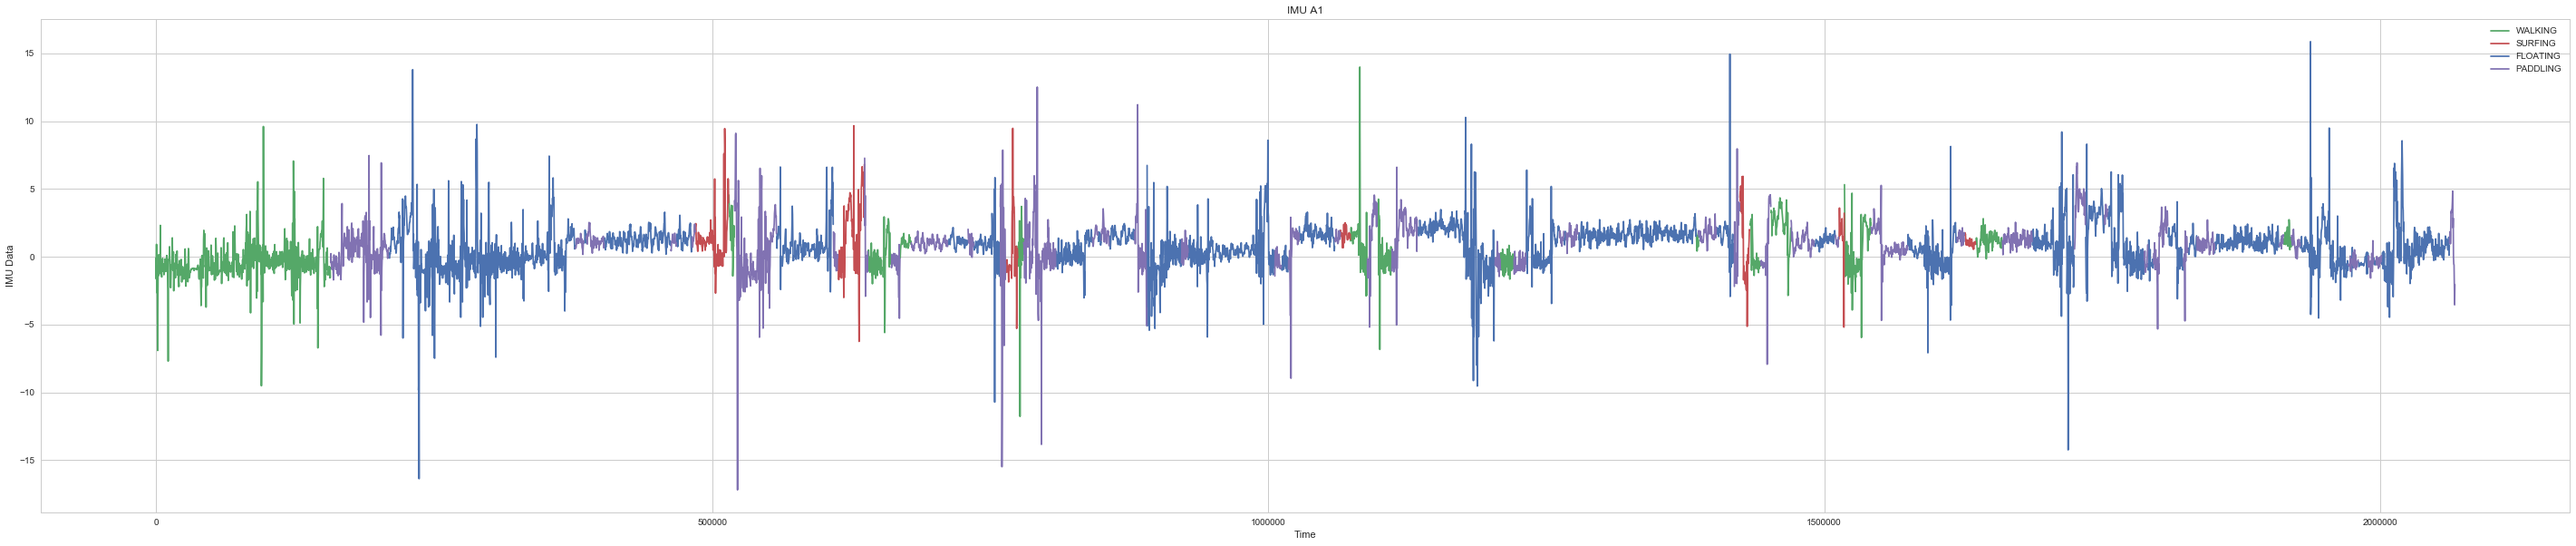

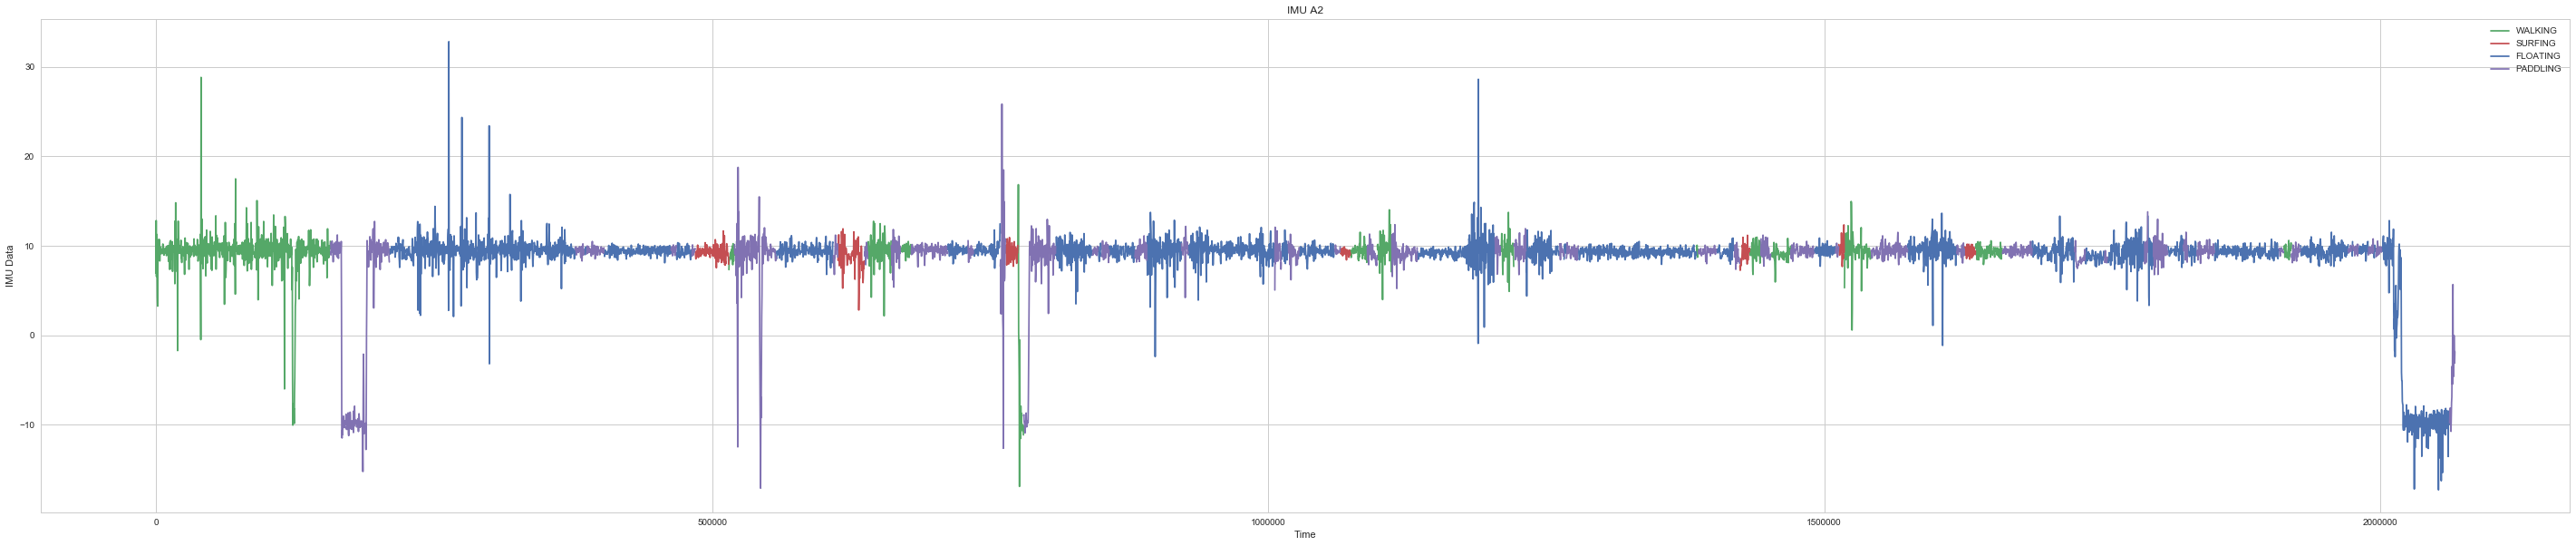

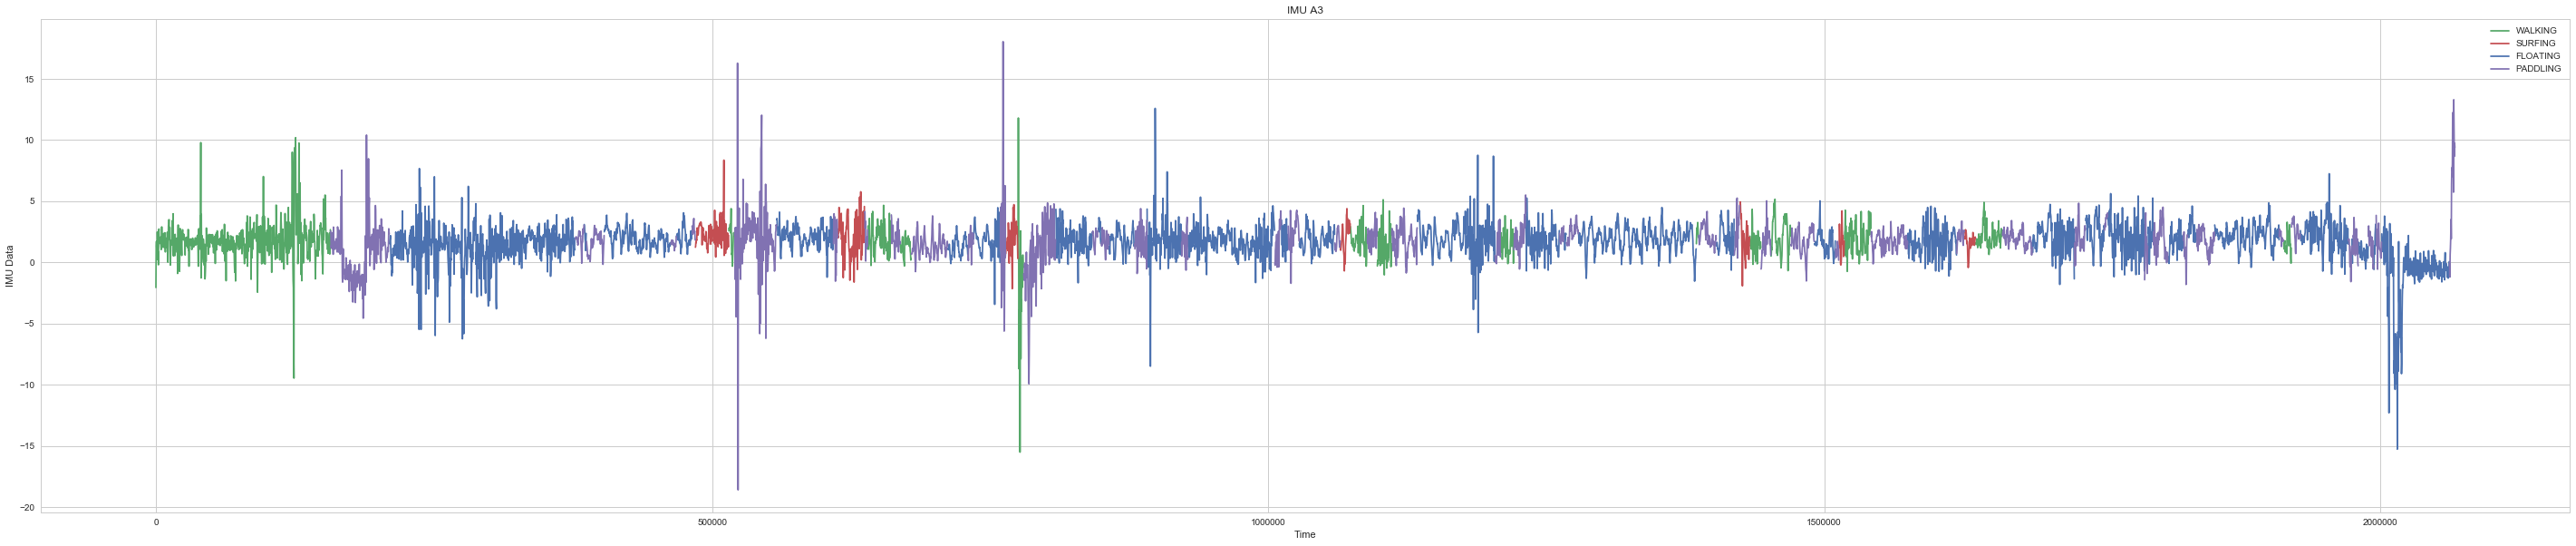

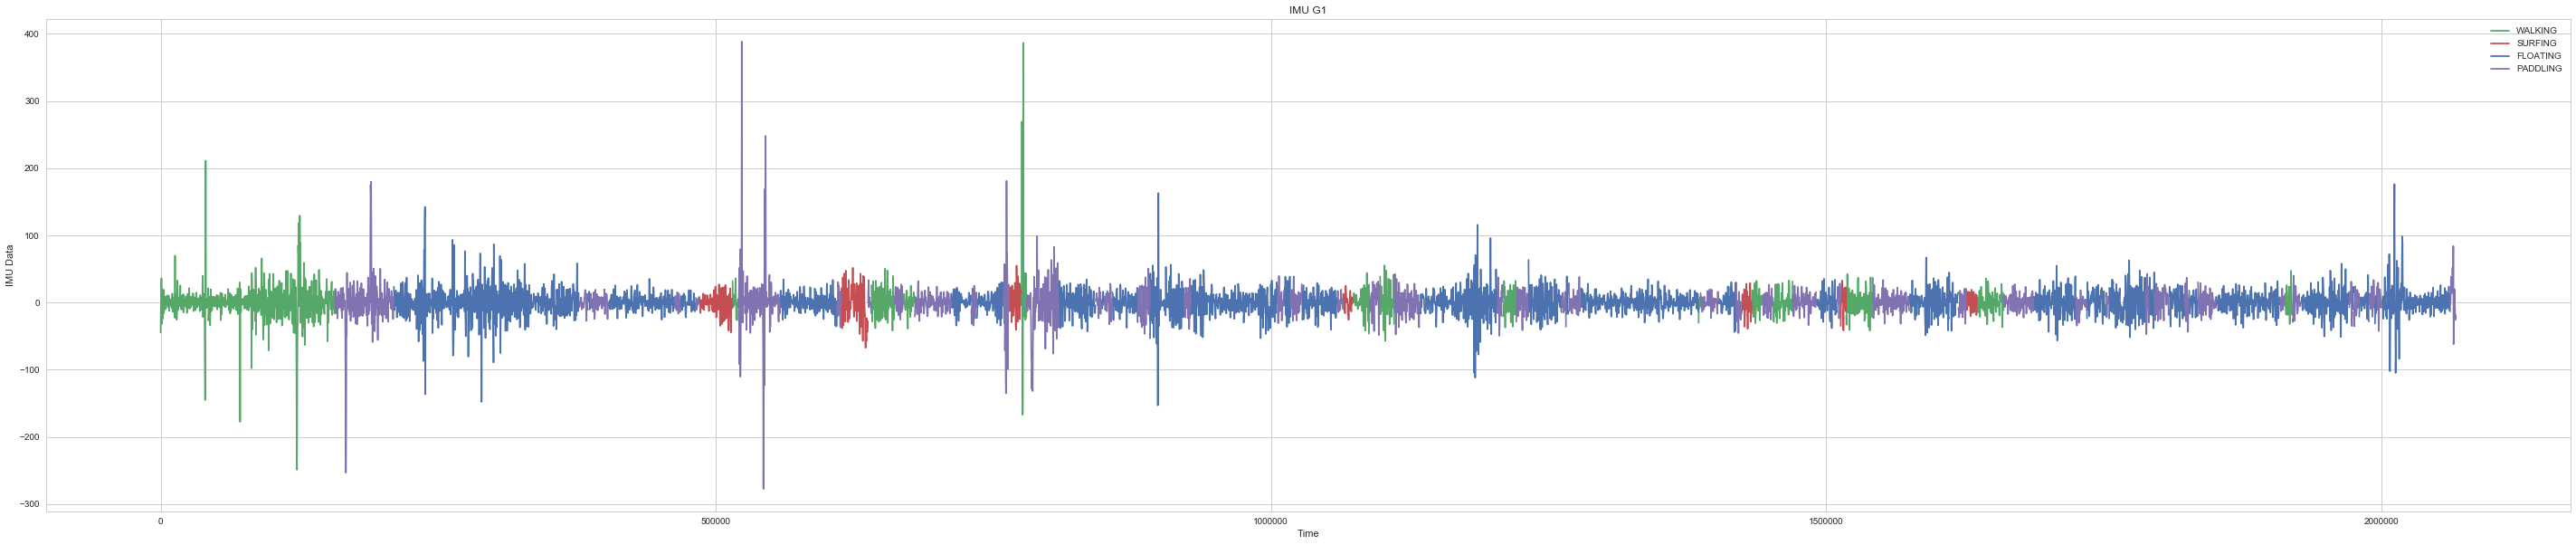

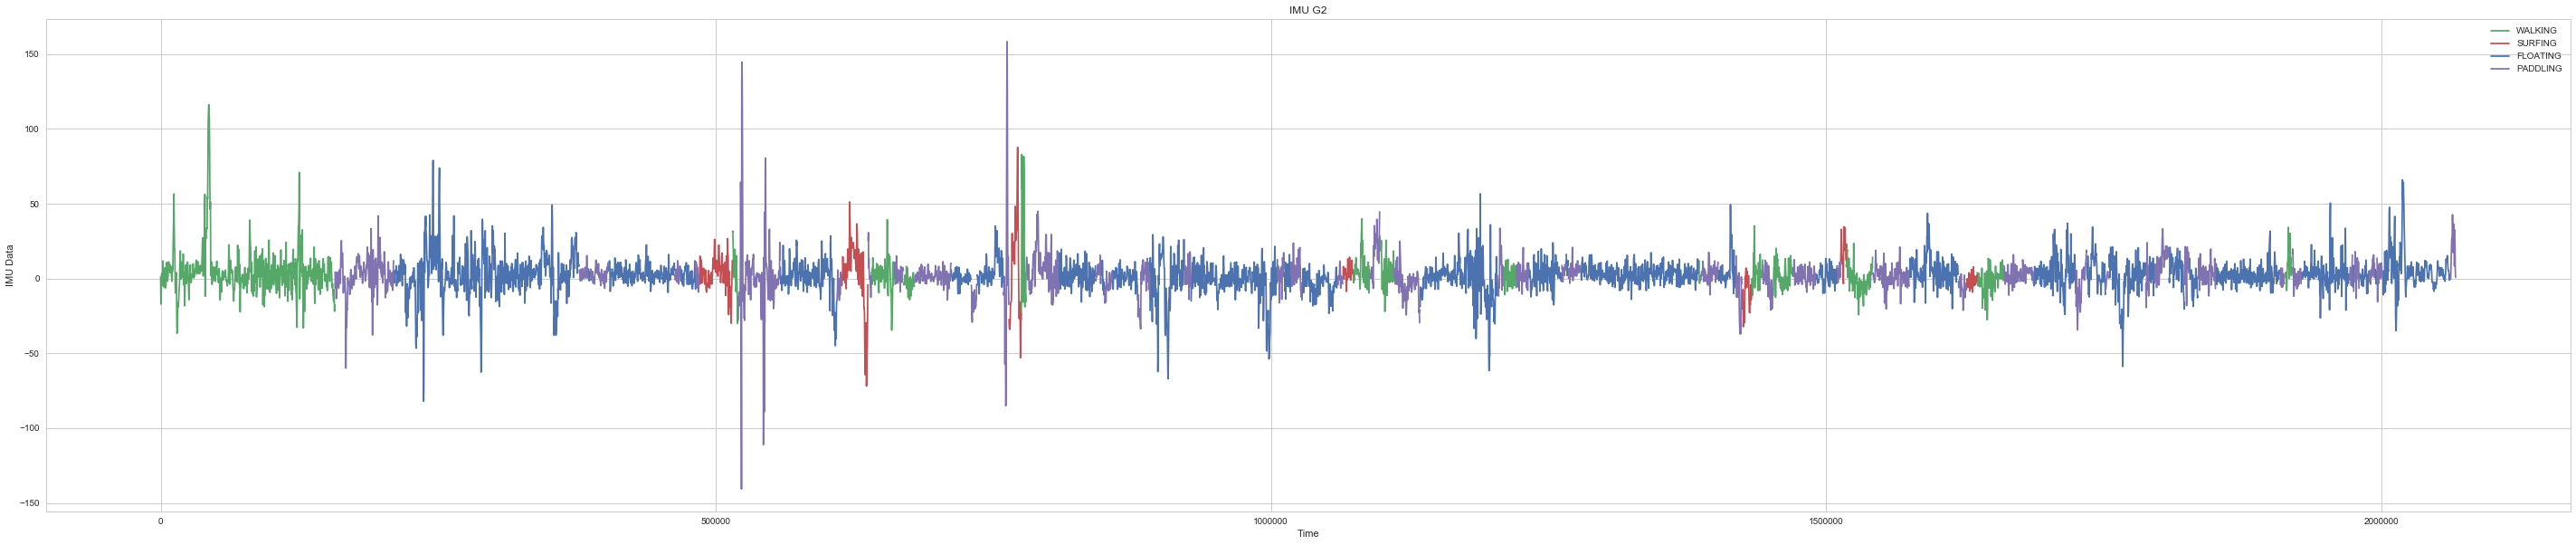

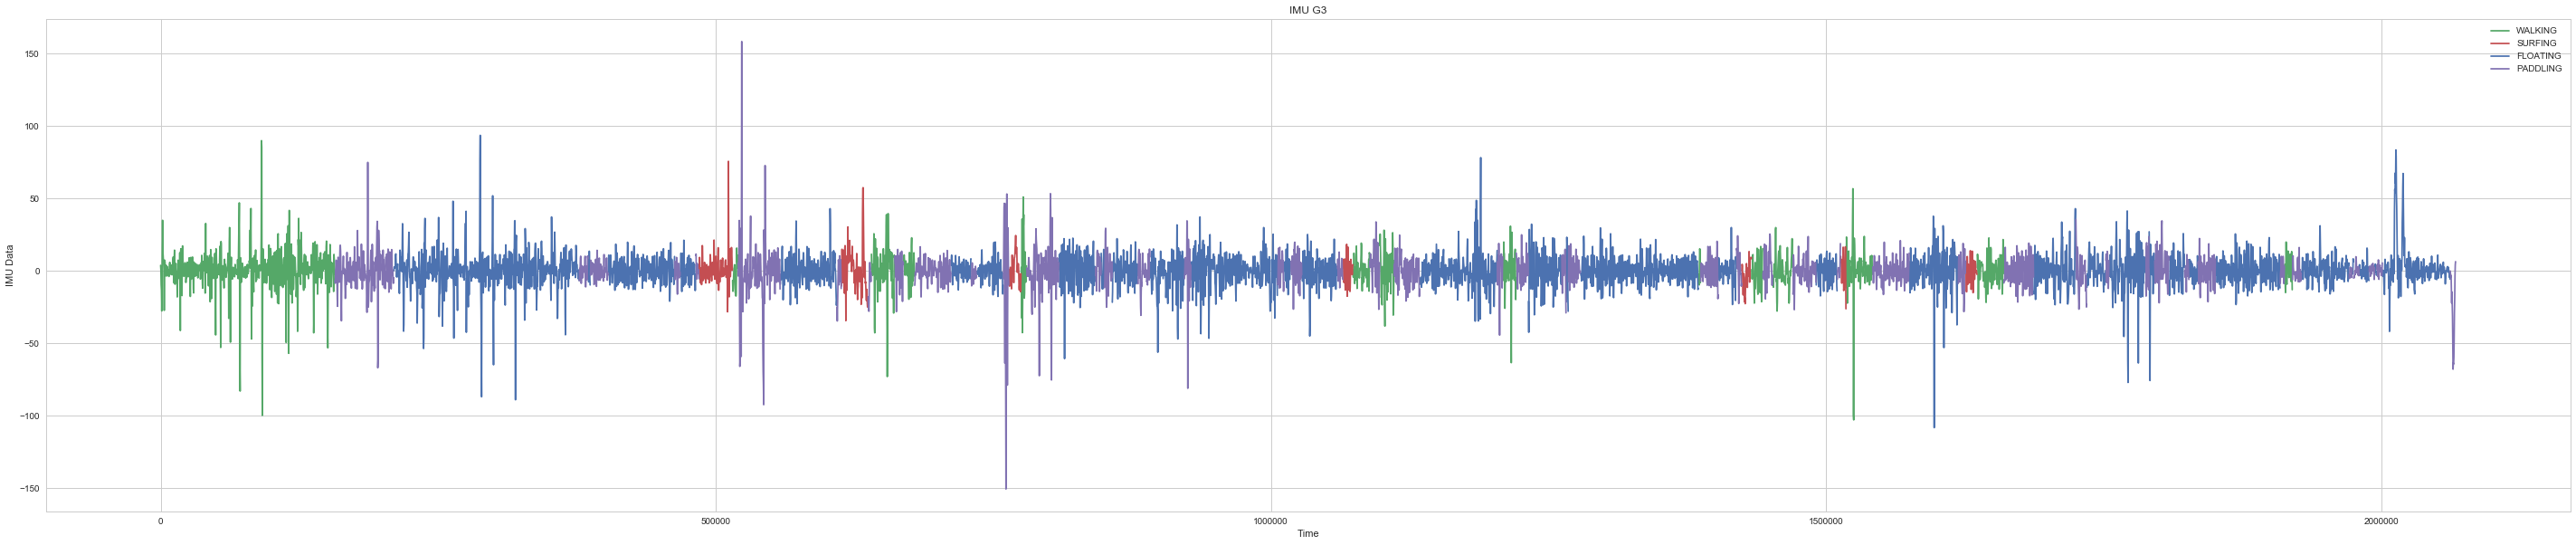

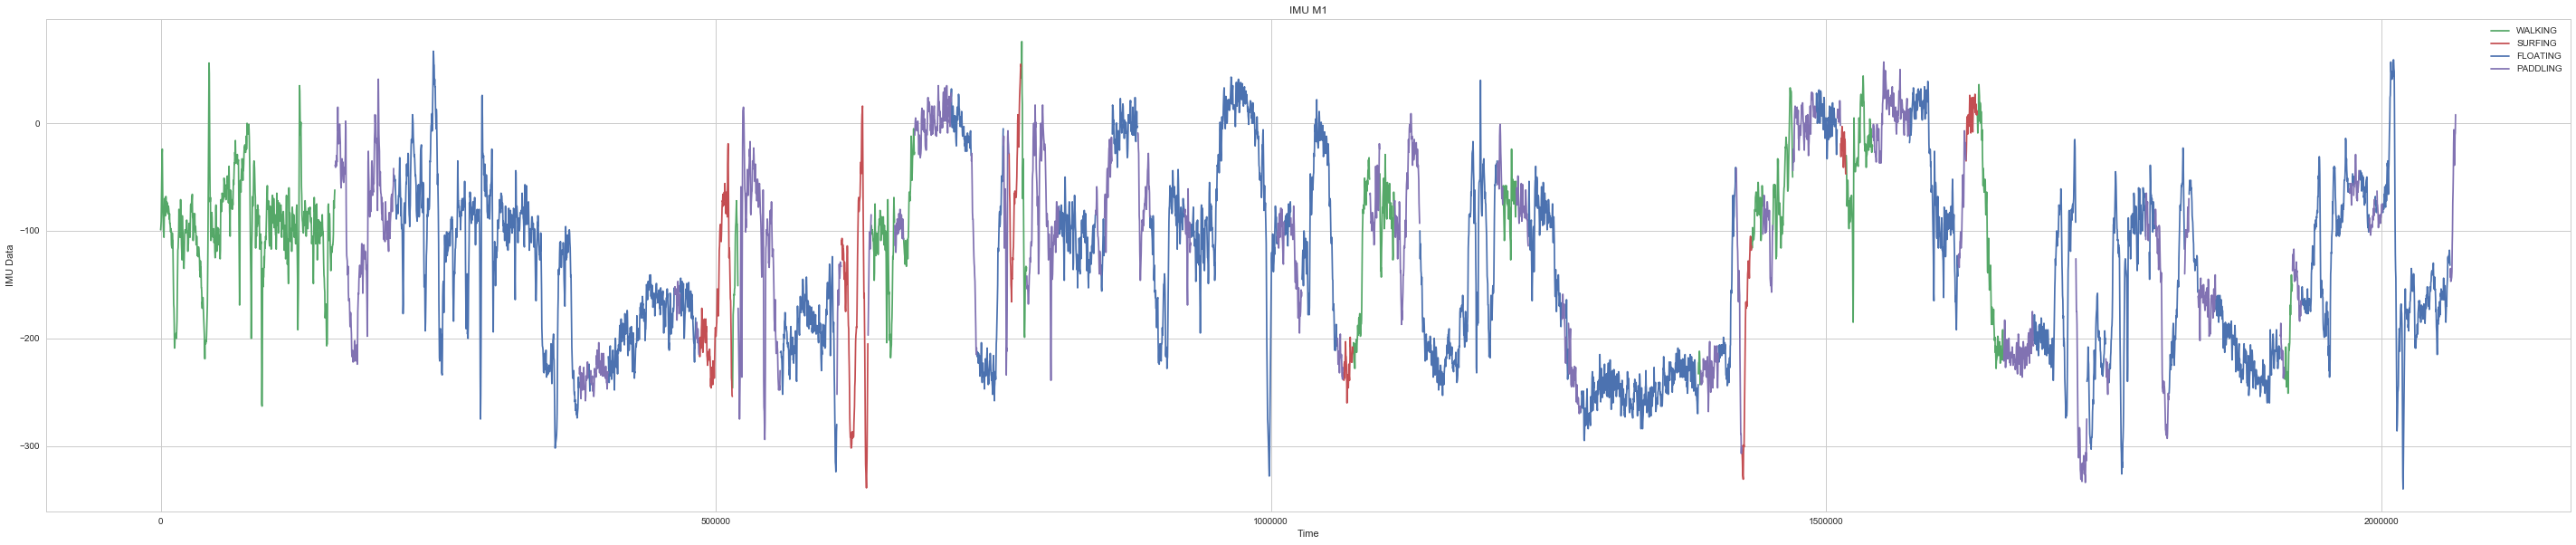

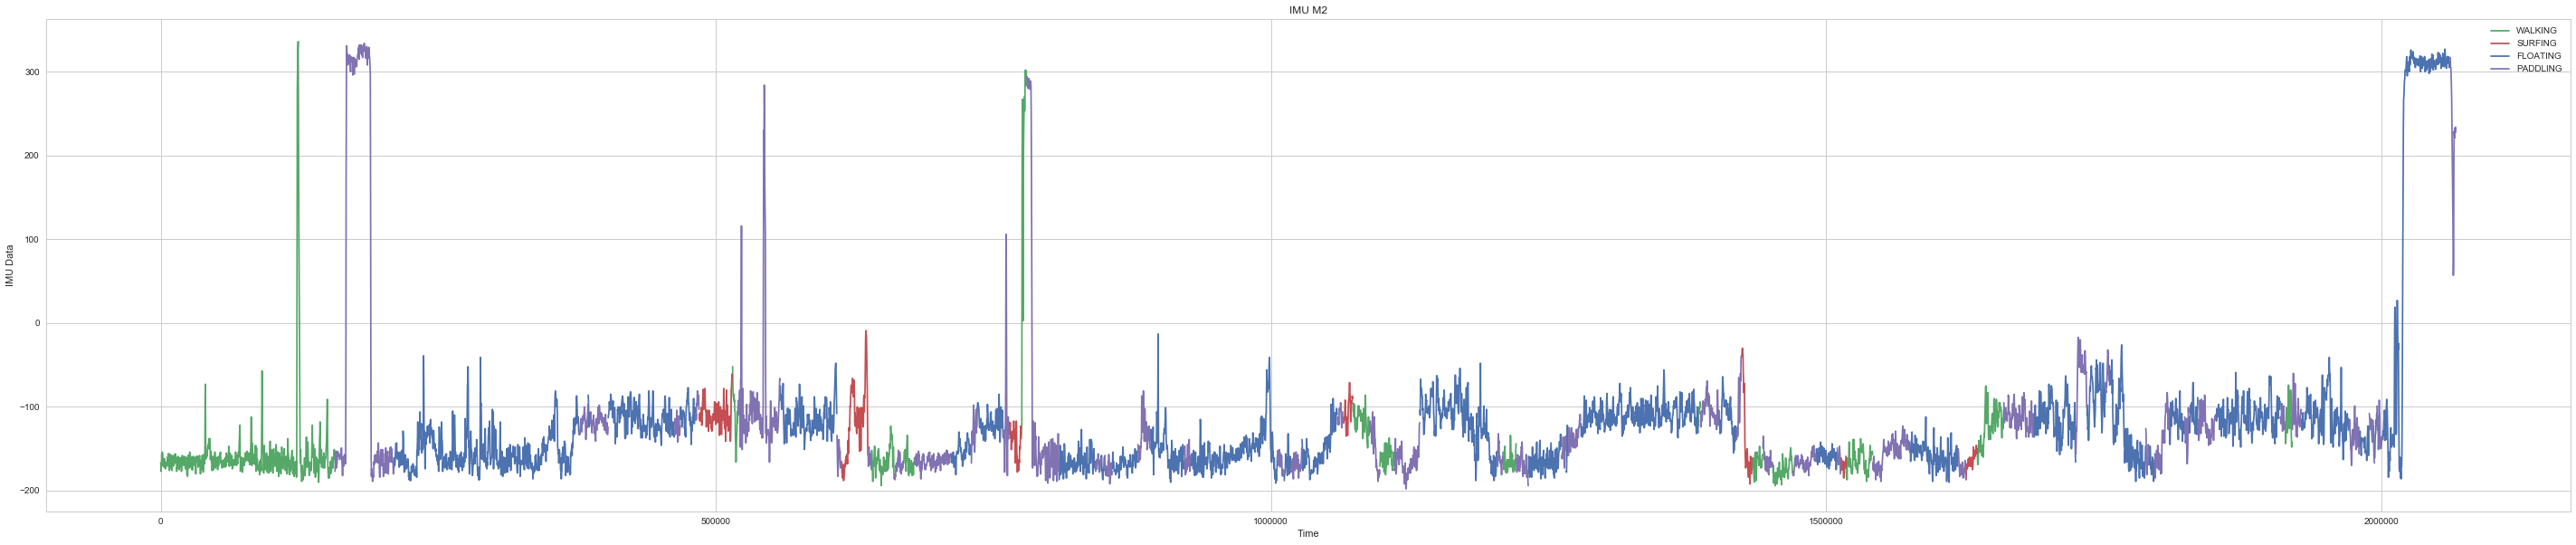

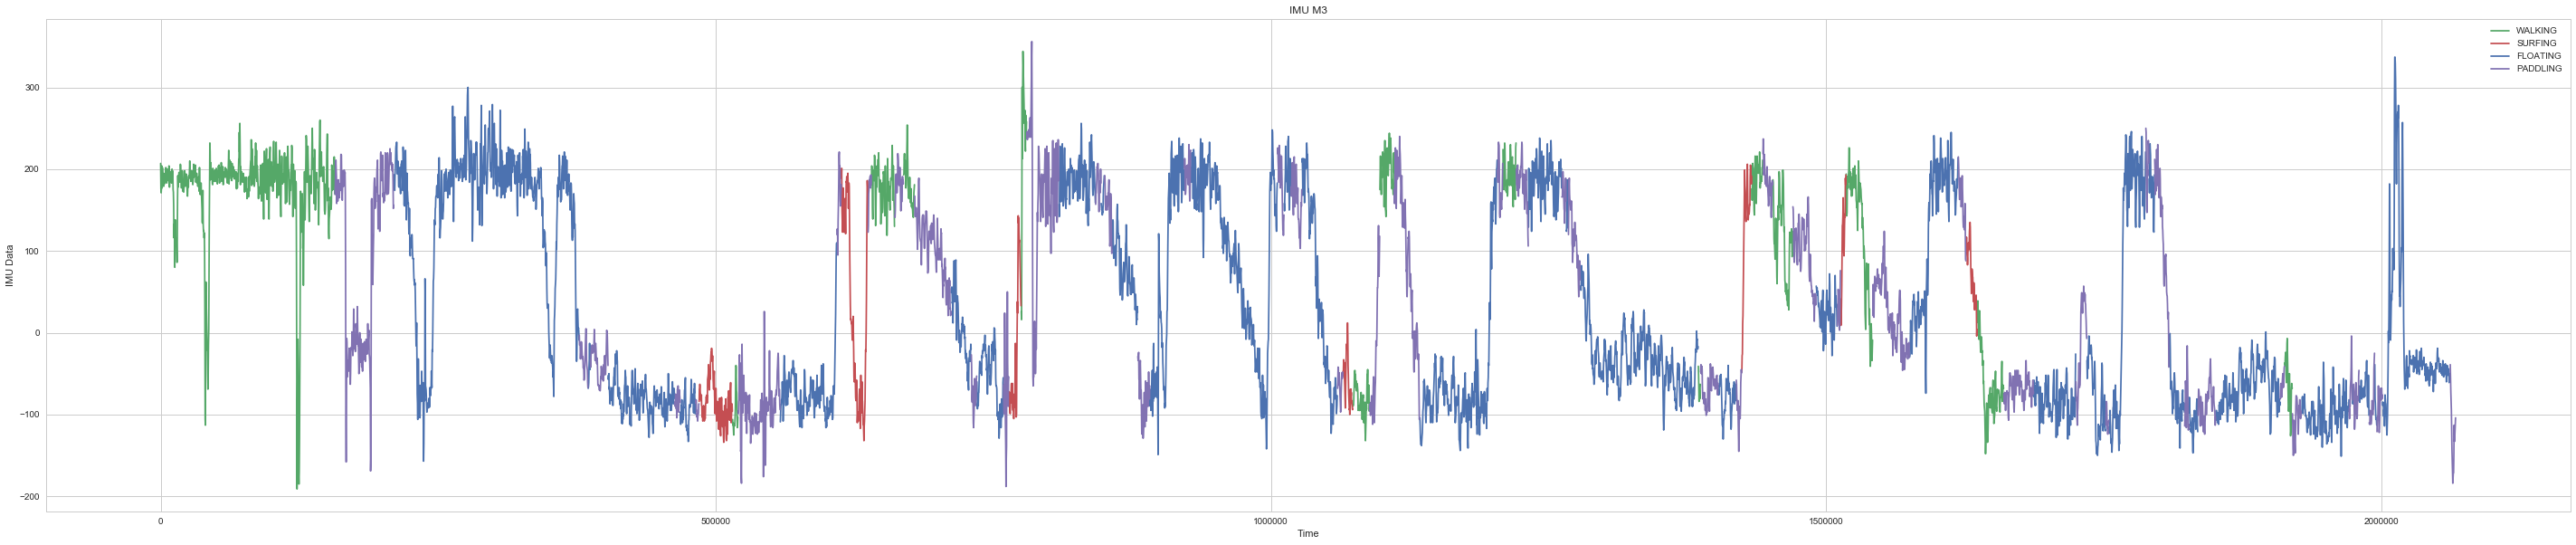

In [11]:
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
createPlot(df_converted,'IMU G1')
createPlot(df_converted,'IMU G2')
createPlot(df_converted,'IMU G3')
createPlot(df_converted,'IMU M1')
createPlot(df_converted,'IMU M2')
createPlot(df_converted,'IMU M3')


In [12]:
#If we ever need to calculate averages from data rows/columns here's a link to do that:
#https://stackoverflow.com/questions/31698861/add-column-to-the-end-of-pandas-dataframe-containing-average-of-previous-data



In [13]:
sns.lineplot(x = "TIME", y = "WALKING", data = testPlot)


AttributeError: module 'seaborn' has no attribute 'lineplot'